# Survival Analysis

Here we walk through survival analysis using the `lifelines` package. 

In [29]:
%matplotlib inline

import lifelines
from lifelines.datasets import load_rossi
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

from lifelines.utils import concordance_index

from matplotlib import pyplot as plt

The Rossi dataset involves recidivism, which is is the act of recommiting a crime.

Week is the duration. Arrest is whether or not an arrest occured, and the other columns are potential columns to regress against.

In [7]:
rossi = load_rossi()
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


## Kaplan-Meier Curve



First we examine the Kaplan-Meier Curve, which is a non-parametric model. 

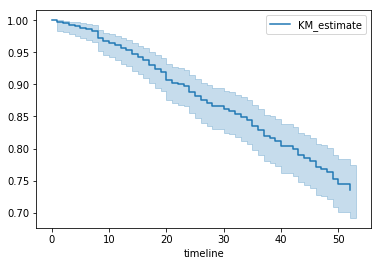

In [16]:
kmf = KaplanMeierFitter()
kmf.fit(rossi['week'], event_observed=rossi['arrest'])
kmf.plot()

The KM curve only uses 1) the observed times and 2) whether or not the time was censored or the adverse event was observed. If we want to examine the impact of other features, one common method is to plot both curves.

Below we separate out the dataset into `race=0` and `race=1`. We see that the KM curves overlap in confidence interval, leading us to conclude that the survival curves are not statistically different for the two races.

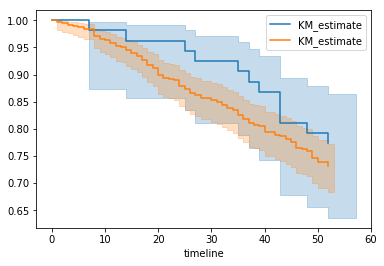

In [24]:
ax = plt.subplot(111)

race0 = rossi[rossi['race'] == 0]
kmf = KaplanMeierFitter()
kmf.fit(race0['week'], event_observed=race0['arrest'])
kmf.plot(ax=ax)

race1 = rossi[rossi['race'] == 1]
# kmf = KaplanMeierFitter()
kmf.fit(race1['week'], event_observed=race1['arrest'])
kmf.plot(ax=ax)

plt.show()

## Cox Propotional Hazards

In contrast, the Cox Proportional Hazards model is semi-parametric, meaning it follows a proportional hazards assumption but does not require knowledge about the time to event distribution. It uses both the covariates X and the provided times y as well as whether the observed event was censored or not.

Below, we see that we can examine the coefficient of each covariate as well as the statistical significance.

In [27]:
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.48337, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-02-22 18:16:31 UTC

---
      coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  uppe

Additionally we can check whether or not our data violates our proportional hazards assumption.

In [28]:
cph.check_assumptions(rossi)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
degrees_of_freedom = 1
 null_distribution = chi squared
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.09 <0.005     10.17
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.16
mar  km              0.60   0.44      1.19
     rank            0.67   0.41      1.27
paro km              0.12   0.73      0.45
     rank            0.14   0.71      0.49
prio km   